In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from scipy import stats

In [2]:
tr = pd.read_csv('train.csv')
te = pd.read_csv('test.csv')

In [3]:
print("\nSTEP 1: EDA")
print("Train shape:", tr.shape)
print("Test shape:", te.shape)
print("\nTrain dtypes & memory info:")
print(tr.info(memory_usage='deep'))

print("\nMissing values per column (train):")
print(tr.isnull().sum())

print("\nActivity distribution:")
print(tr['Activity'].value_counts())

# Numeric feature list (exclude subject)
num_cols = tr.select_dtypes(include=[np.number]).columns.tolist()
if 'subject' in num_cols:
    num_cols.remove('subject')


STEP 1: EDA
Train shape: (7352, 563)
Test shape: (2947, 563)

Train dtypes & memory info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.9 MB
None

Missing values per column (train):
tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

Activity distribution:
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


In [4]:
# Correlation matrix and top-20-by-variance selection
corr = tr[num_cols].corr()
var_s = tr[num_cols].var().sort_values(ascending=False)
top_feats = var_s.index[:20].tolist()
corr_top = tr[top_feats].corr()

In [5]:
# Highly correlated feature pairs (abs>0.85)
high_corr_pairs = []
for i in range(len(top_feats)):
    for j in range(i+1, len(top_feats)):
        a = top_feats[i]; b = top_feats[j]
        val = corr_top.loc[a,b]
        if abs(val) > 0.85:
            high_corr_pairs.append((a,b,val))
print("\nHighly correlated feature pairs (abs>0.85):", high_corr_pairs if high_corr_pairs else "None found")


Highly correlated feature pairs (abs>0.85): [('fBodyAccJerk-entropy()-X', 'fBodyAccJerk-entropy()-Y', 0.9886657965060963), ('fBodyAccJerk-entropy()-X', 'tBodyAccJerkMag-entropy()', 0.9880293929137463), ('fBodyAccJerk-entropy()-X', 'fBodyAcc-entropy()-X', 0.9898623110009315), ('fBodyAccJerk-entropy()-X', 'tBodyGyroJerkMag-entropy()', 0.9515813751891079), ('fBodyAccJerk-entropy()-X', 'fBodyAccMag-entropy()', 0.97699011644684), ('fBodyAccJerk-entropy()-X', 'tBodyAccMag-entropy()', 0.9371907644617109), ('fBodyAccJerk-entropy()-X', 'tGravityAccMag-entropy()', 0.9371907644617109), ('fBodyAccJerk-entropy()-X', 'fBodyBodyAccJerkMag-entropy()', 0.9925834842509313), ('fBodyAccJerk-entropy()-X', 'fBodyAcc-entropy()-Y', 0.9744449558327373), ('fBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-X', 0.9782027234938635), ('fBodyAccJerk-entropy()-X', 'fBodyAccJerk-entropy()-Z', 0.9790376767621519), ('fBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Y', 0.9740745757813654), ('fBodyAccJerk-entropy()-X

In [6]:

# Correlation with target (encoded)
le_tmp = LabelEncoder()
y_num = le_tmp.fit_transform(tr['Activity'])
corr_with_target = tr[num_cols].corrwith(pd.Series(y_num, index=tr.index)).sort_values(key=lambda x: abs(x), ascending=False)
print("\nTop numeric features correlated with Activity (by abs correlation):")
print(corr_with_target.head(10))


Top numeric features correlated with Activity (by abs correlation):
fBodyAccJerk-entropy()-X     0.845190
tBodyGyroJerk-entropy()-Z    0.844754
tBodyAccJerk-entropy()-Y     0.837034
tBodyAcc-sma()               0.835621
tBodyAccJerkMag-entropy()    0.835376
tGravityAccMag-mean()        0.833126
tBodyAccMag-sma()            0.833126
tGravityAccMag-sma()         0.833126
tBodyAccMag-mean()           0.833126
fBodyAccJerk-entropy()-Y     0.832284
dtype: float64


In [7]:
# Subject vs Activity counts
ct = tr.groupby(['subject','Activity']).size().unstack(fill_value=0)
print("\nSubject x Activity counts (first rows):")
print(ct.head())

most_freq_per_subj = ct.idxmax(axis=1).sort_index()
print("\nMost frequent activity per subject (first 10 subjects):")
print(most_freq_per_subj.head(10))


Subject x Activity counts (first rows):
Activity  LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
subject                                                            
1             50       47        53       95                  49   
3             62       52        61       58                  49   
5             52       44        56       56                  47   
6             57       55        57       57                  48   
7             52       48        53       57                  47   

Activity  WALKING_UPSTAIRS  
subject                     
1                       53  
3                       59  
5                       47  
6                       51  
7                       51  

Most frequent activity per subject (first 10 subjects):
subject
1      WALKING
3       LAYING
5     STANDING
6       LAYING
7      WALKING
8       LAYING
11     WALKING
14    STANDING
15      LAYING
16    STANDING
dtype: object


In [8]:
# PCA (first 2) for visualization
sc = StandardScaler()
Xsc = sc.fit_transform(tr[num_cols])
pca = PCA(n_components=2, random_state=0)
pc = pca.fit_transform(Xsc)
print("\nExplained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)


Explained variance ratio (PC1, PC2): [0.50781172 0.0658068 ]


In [9]:
# Grouped mean & std by Activity
grp = tr.groupby('Activity')[num_cols].agg(['mean','std'])
print("\nGroup stats (mean/std) snippet:")
print(grp.iloc[:, :6].head())


Group stats (mean/std) snippet:
                   tBodyAcc-mean()-X           tBodyAcc-mean()-Y            \
                                mean       std              mean       std   
Activity                                                                     
LAYING                      0.269191  0.101541         -0.018345  0.073512   
SITTING                     0.273449  0.041998         -0.012143  0.032421   
STANDING                    0.279294  0.020097         -0.016123  0.017846   
WALKING                     0.276260  0.050353         -0.017768  0.020880   
WALKING_DOWNSTAIRS          0.288169  0.095101         -0.016370  0.027057   

                   tBodyAcc-mean()-Z            
                                mean       std  
Activity                                        
LAYING                     -0.107169  0.089743  
SITTING                    -0.106581  0.045323  
STANDING                   -0.107330  0.035680  
WALKING                    -0.108884  0.032436  

In [10]:
# Example specific answers (feature names exist in dataset)
feat_x = 'tBodyAcc-mean()-X' if 'tBodyAcc-mean()-X' in tr.columns else num_cols[0]
mean_by_activity = tr.groupby('Activity')[feat_x].mean().sort_values(ascending=False)
print(f"\nActivity with highest average {feat_x}:")
print(mean_by_activity)

gyro_feat = 'tBodyGyro-std()-Z'
if gyro_feat in tr.columns:
    std_by_activity = tr.groupby('Activity')[gyro_feat].std().sort_values()
    print(f"\nActivity with least variability in {gyro_feat}:")
    print(std_by_activity)
else:
    print(f"\n{gyro_feat} not available in data; skipping gyro variability check.")


Activity with highest average tBodyAcc-mean()-X:
Activity
WALKING_DOWNSTAIRS    0.288169
STANDING              0.279294
WALKING               0.276260
SITTING               0.273449
LAYING                0.269191
WALKING_UPSTAIRS      0.261930
Name: tBodyAcc-mean()-X, dtype: float64

Activity with least variability in tBodyGyro-std()-Z:
Activity
STANDING              0.050078
SITTING               0.062615
LAYING                0.066941
WALKING               0.158127
WALKING_DOWNSTAIRS    0.203517
WALKING_UPSTAIRS      0.313776
Name: tBodyGyro-std()-Z, dtype: float64


In [11]:
# Multi-index aggregation
stat_feat1 = feat_x
stat_feat2 = 'tBodyAcc-std()-Y' if 'tBodyAcc-std()-Y' in tr.columns else num_cols[1]
mi = tr.groupby(['subject','Activity']).agg(
    mean_tBodyAcc_mean_X = (stat_feat1,'mean'),
    median_tBodyAcc_std_Y = (stat_feat2,'median'),
    obs_count = ('Activity','size')
)
print("\nMulti-index aggregated snippet:")
print(mi.head(10))


Multi-index aggregated snippet:
                            mean_tBodyAcc_mean_X  median_tBodyAcc_std_Y  \
subject Activity                                                          
1       LAYING                          0.221598              -0.986031   
        SITTING                         0.261238              -0.981925   
        STANDING                        0.278918              -0.983941   
        WALKING                         0.277331               0.122801   
        WALKING_DOWNSTAIRS              0.289188              -0.035746   
        WALKING_UPSTAIRS                0.255462               0.001220   
3       LAYING                          0.275517              -0.979811   
        SITTING                         0.257198              -0.957723   
        STANDING                        0.280047              -0.916457   
        WALKING                         0.275567              -0.070386   

                            obs_count  
subject Activity          

In [12]:
# STEP 2: VISUALIZATIONS
print("\nSTEP 2: VISUALIZATIONS (plots will appear)")



STEP 2: VISUALIZATIONS (plots will appear)


<Figure size 1200x500 with 0 Axes>

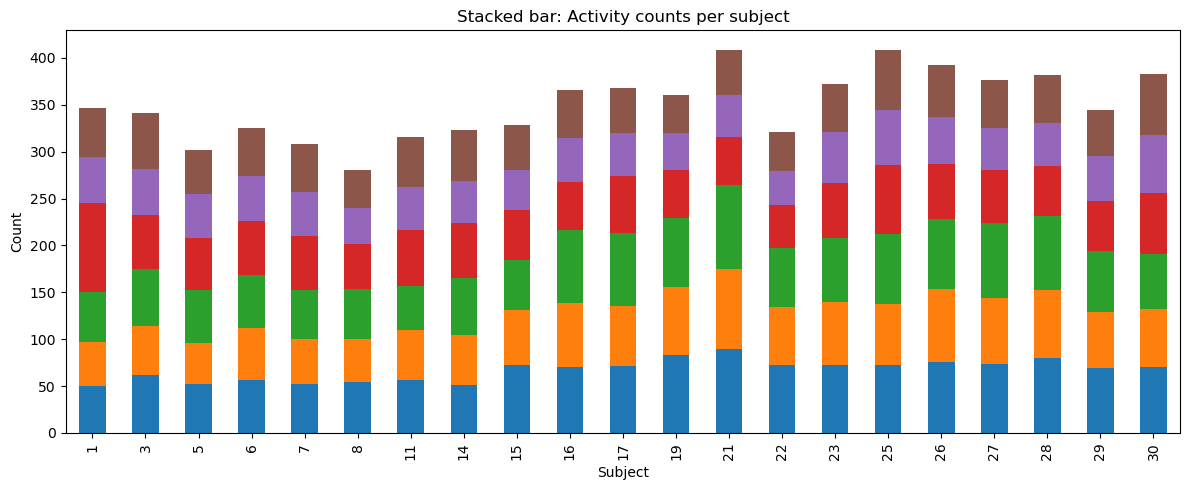

In [13]:
# Stacked bar chart (activities per subject)
plt.figure(figsize=(12,5))
ct.plot(kind='bar', stacked=True, figsize=(12,5), legend=False)
plt.title('Stacked bar: Activity counts per subject')
plt.xlabel('Subject'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


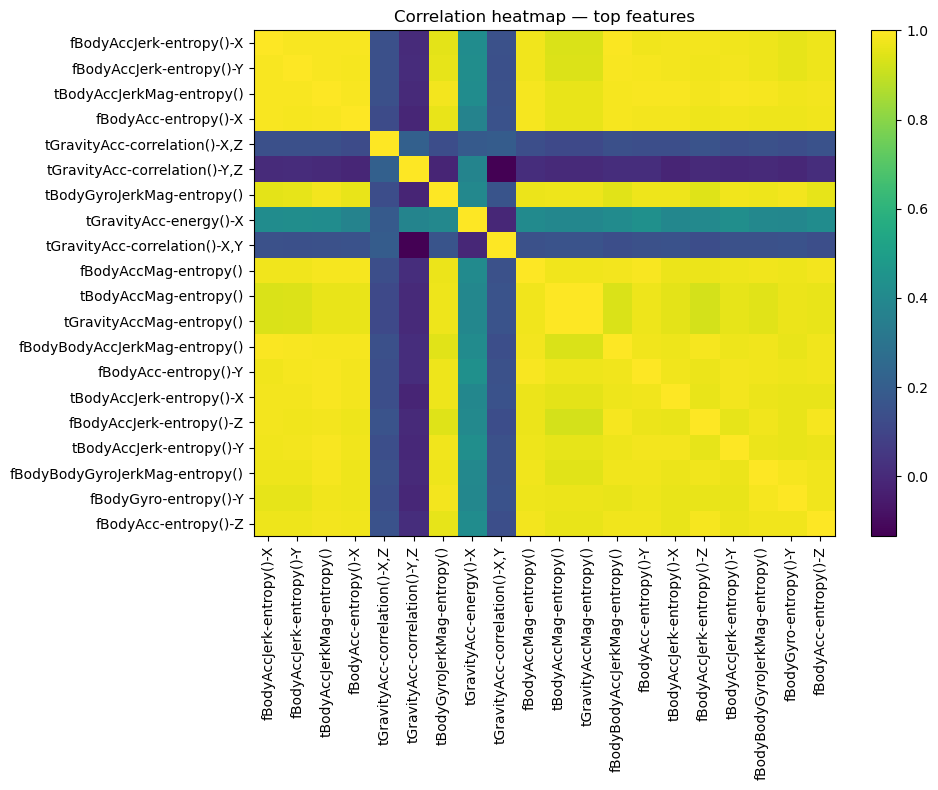

In [14]:
# Heatmap of top-20 correlations
plt.figure(figsize=(10,8))
plt.imshow(corr_top, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(top_feats)), top_feats, rotation=90)
plt.yticks(range(len(top_feats)), top_feats)
plt.title('Correlation heatmap — top features'); plt.tight_layout(); plt.show()

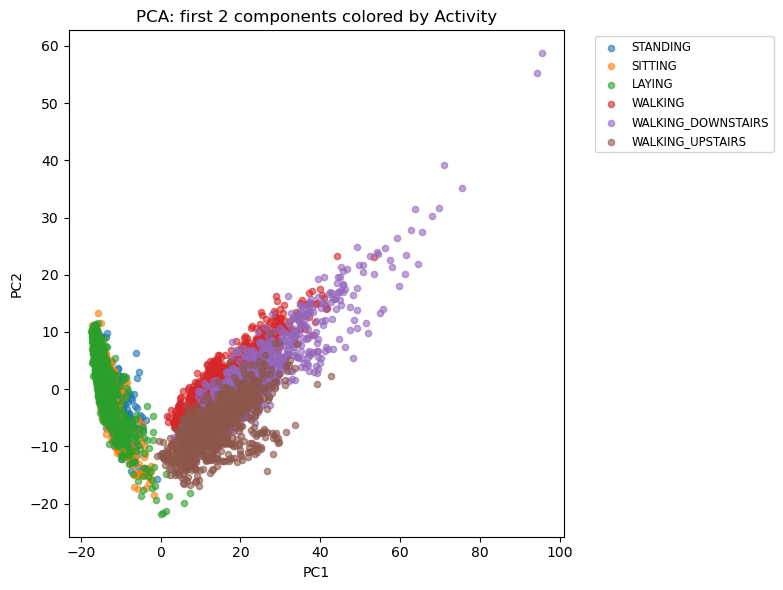

In [15]:
# PCA scatter colored by Activity
plt.figure(figsize=(8,6))
for a in tr['Activity'].unique():
    idx = tr['Activity']==a
    plt.scatter(pc[idx,0], pc[idx,1], label=a, alpha=0.6, s=20)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA: first 2 components colored by Activity'); plt.tight_layout(); plt.show()

C:\Users\91970\AppData\Local\Temp\ipykernel_19424\1992940623.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=acts, showfliers=False)


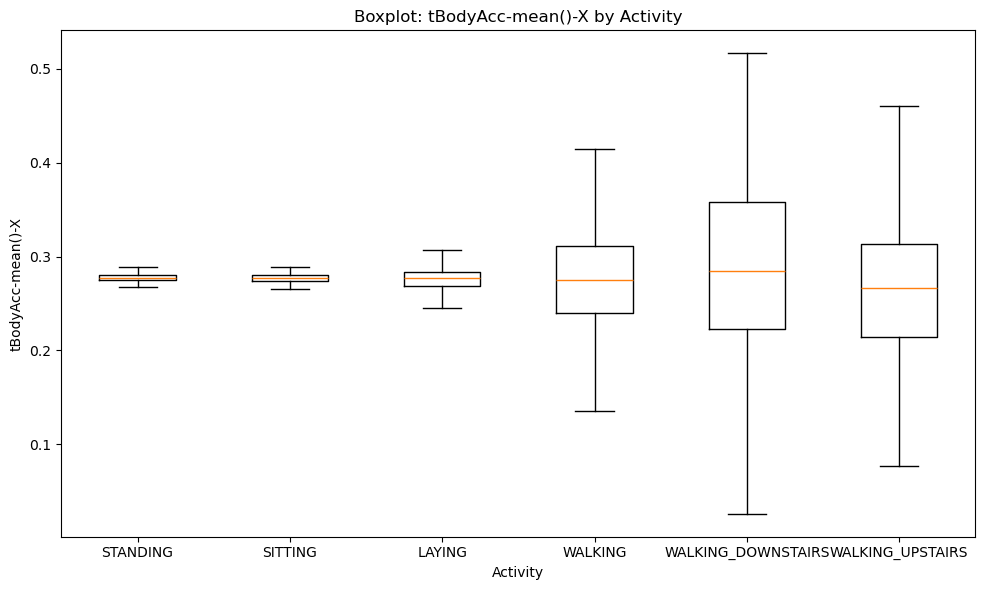

Activity with largest IQR: WALKING_DOWNSTAIRS


In [16]:
# Boxplot for tBodyAcc-mean()-X
if feat_x in tr.columns:
    plt.figure(figsize=(10,6))
    acts = tr['Activity'].unique()
    data_to_plot = [tr[tr['Activity']==a][feat_x] for a in acts]
    plt.boxplot(data_to_plot, labels=acts, showfliers=False)
    plt.title(f'Boxplot: {feat_x} by Activity'); plt.xlabel('Activity'); plt.ylabel(feat_x); plt.tight_layout(); plt.show()
    spreads = [arr.dropna().quantile(0.75)-arr.dropna().quantile(0.25) for arr in data_to_plot]
    print("Activity with largest IQR:", acts[np.argmax(spreads)])

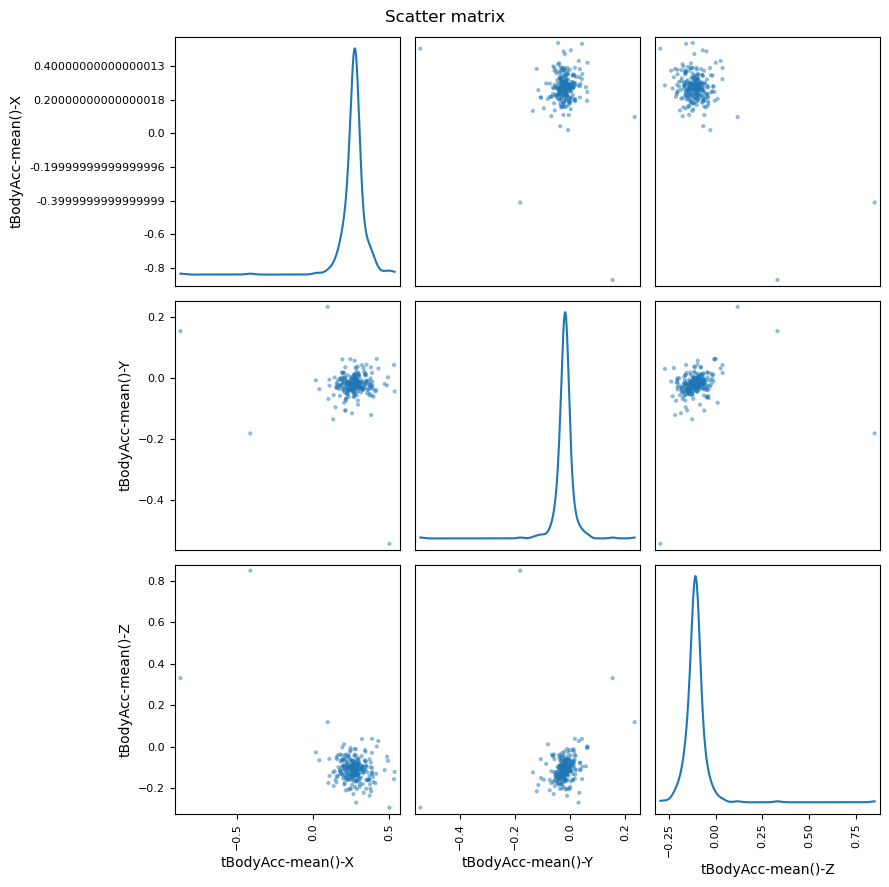

In [17]:
# Scatter-matrix for selected features
sel = [c for c in ['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z'] if c in tr.columns]
if len(sel)>=2:
    pd.plotting.scatter_matrix(tr[sel].sample(min(400, len(tr))).dropna(), figsize=(9,9), diagonal='kde'); plt.suptitle('Scatter matrix'); plt.tight_layout(); plt.show()

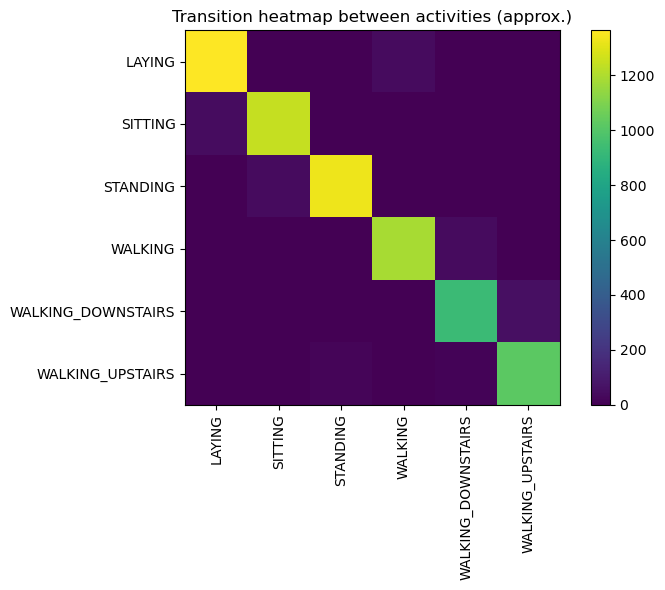

In [18]:
# Transition heatmap (approximate)
trans_counts = {}
for sub, df_sub in tr.groupby('subject'):
    acts_seq = df_sub['Activity'].values
    for i in range(len(acts_seq)-1):
        a1 = acts_seq[i]; a2 = acts_seq[i+1]
        trans_counts[(a1,a2)] = trans_counts.get((a1,a2), 0) + 1
acts_list = sorted(tr['Activity'].unique())
tc_mat = pd.DataFrame(0, index=acts_list, columns=acts_list)
for (a1,a2), v in trans_counts.items():
    tc_mat.loc[a1,a2] = v
plt.figure(figsize=(8,6)); plt.imshow(tc_mat, interpolation='nearest'); plt.colorbar()
plt.xticks(range(len(acts_list)), acts_list, rotation=90); plt.yticks(range(len(acts_list)), acts_list)
plt.title('Transition heatmap between activities (approx.)'); plt.tight_layout(); plt.show()

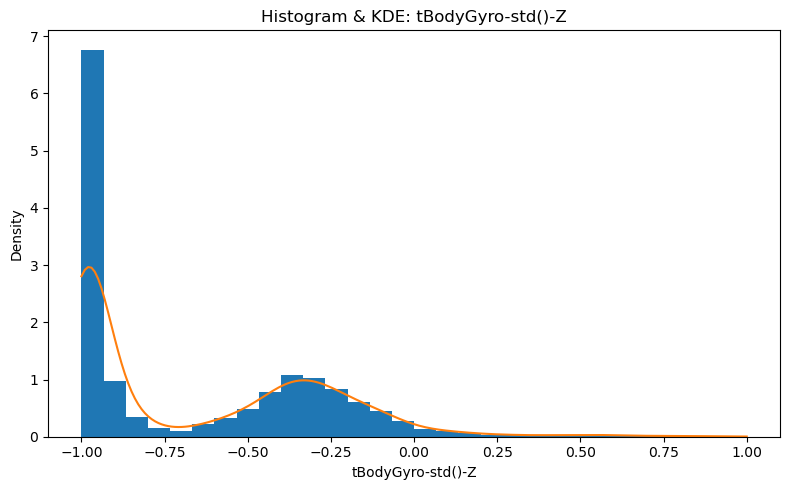

Skewness: 0.820201344492315


In [19]:
# Histogram & KDE of tBodyGyro-std()-Z (if available)
if 'tBodyGyro-std()-Z' in tr.columns:
    plt.figure(figsize=(8,5))
    plt.hist(tr['tBodyGyro-std()-Z'].dropna(), bins=30, density=True)
    try:
        kde = stats.gaussian_kde(tr['tBodyGyro-std()-Z'].dropna())
        xs = np.linspace(tr['tBodyGyro-std()-Z'].min(), tr['tBodyGyro-std()-Z'].max(), 200)
        plt.plot(xs, kde(xs))
    except:
        pass
    plt.title('Histogram & KDE: tBodyGyro-std()-Z'); plt.xlabel('tBodyGyro-std()-Z'); plt.ylabel('Density'); plt.tight_layout(); plt.show()
    print("Skewness:", tr['tBodyGyro-std()-Z'].skew())

In [20]:
# STEP 3: STATISTICAL INFERENCE
print("\nSTEP 3: STATISTICAL INFERENCE")


STEP 3: STATISTICAL INFERENCE


In [21]:

# ANOVA across activities for tBodyAcc-mean()-X
if feat_x in tr.columns:
    acts = tr['Activity'].unique()
    groups = [tr[tr['Activity']==a][feat_x].dropna() for a in acts]
    fval, pval = stats.f_oneway(*groups)
    print("ANOVA F:", fval, "p:", pval)
    # 95% CI per activity for feat_x
    print("95% CI for", feat_x)
    for a in acts:
        arr = tr[tr['Activity']==a][feat_x].dropna()
        n = len(arr); m = arr.mean(); s = arr.std(ddof=1)
        se = s/np.sqrt(n) if n>0 else np.nan
        print(a, "mean:", m, "95% CI:", (m-1.96*se, m+1.96*se), "n:", n)

ANOVA F: 17.626909914888536 p: 2.1154643414919055e-17
95% CI for tBodyAcc-mean()-X
STANDING mean: 0.2792937570742358 95% CI: (0.27823109072458097, 0.28035642342389067) n: 1374
SITTING mean: 0.27344899882542767 95% CI: (0.2711535939780865, 0.2757444036727688) n: 1286
LAYING mean: 0.2691910070887705 95% CI: (0.26388519036071456, 0.2744968238168264) n: 1407
WALKING mean: 0.27626020087275693 95% CI: (0.2734415921742977, 0.27907880957121617) n: 1226
WALKING_DOWNSTAIRS mean: 0.28816888847565925 95% CI: (0.28223274657002734, 0.29410503038129115) n: 986
WALKING_UPSTAIRS mean: 0.2619295272520037 95% CI: (0.2572606729545063, 0.2665983815495011) n: 1073


In [22]:

# Example t-test: WALKING vs SITTING (if present)
if 'WALKING' in tr['Activity'].unique() and 'SITTING' in tr['Activity'].unique() and feat_x in tr.columns:
    arr1 = tr[tr['Activity']=='WALKING'][feat_x].dropna()
    arr2 = tr[tr['Activity']=='SITTING'][feat_x].dropna()
    t, p = stats.ttest_ind(arr1, arr2, equal_var=False)
    print("T-test WALKING vs SITTING for", feat_x, "t:", t, "p:", p)

T-test WALKING vs SITTING for tBodyAcc-mean()-X t: 1.5157940900567566 p: 0.1297038033942283


In [23]:
# STEP 4: PREPROCESSING & CLEANING
print("\nSTEP 4: PREPROCESSING & CLEANING")


STEP 4: PREPROCESSING & CLEANING


In [24]:
# Missing values: drop rows with >10% missing, median-impute numeric columns
thr = int(0.1 * tr.shape[1])
tr2 = tr.copy().dropna(axis=0, thresh=tr.shape[1]-thr)
for c in tr2.select_dtypes(include=[np.number]).columns:
    if tr2[c].isnull().any():
        tr2[c].fillna(tr2[c].median(), inplace=True)
print("Total missing after simple imputation:", tr2.isnull().sum().sum())

Total missing after simple imputation: 0


In [25]:
# Feature scaling on numeric (exclude subject)
Xnum_cols = tr2.select_dtypes(include=[np.number]).columns.tolist()
if 'subject' in Xnum_cols:
    Xnum_cols.remove('subject')
scaler = StandardScaler()
Xscaled = scaler.fit_transform(tr2[Xnum_cols])

In [26]:

# Label encode Activity
le = LabelEncoder()
y_enc = le.fit_transform(tr2['Activity'])

In [27]:
# Outlier detection via z-score (flag rows with any abs(z)>4)
z = np.abs(stats.zscore(tr2[Xnum_cols], nan_policy='omit'))
outlier_mask = (z > 4).any(axis=1)
print("Outliers flagged:", outlier_mask.sum())

Outliers flagged: 2209


In [28]:
# Remove extremely correlated features (abs > 0.95)
df_num = pd.DataFrame(Xscaled, columns=Xnum_cols)
corrmat = df_num.corr().abs()
upper = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Dropping highly correlated:", to_drop)
df_reduced = df_num.drop(columns=to_drop, errors='ignore')

Dropping highly correlated: ['tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tGravityAcc-mad()-X', 'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X', 'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z', 'tGravityAcc-arCoeff()-X,2', 'tGravityAcc-arCoeff()-X,3', 'tGravityAcc-arCoeff()-X,4', 'tGravityAcc-arCoeff()-Y,2', 'tGravityAcc-arCoeff()-Y,3', 'tGravityAcc-arCoeff()-Y,4', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Z,3', 'tGravityAcc-arCoeff()-Z,4', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-max()-X', 'tBodyAccJerk-max()-Y',

In [29]:
# Stratified split
X_train, X_val, y_train, y_val = train_test_split(df_reduced, y_enc, test_size=0.2, random_state=0, stratify=y_enc)
print("Train/Val sizes:", X_train.shape, X_val.shape)

Train/Val sizes: (5881, 253) (1471, 253)


In [30]:
# STEP 5: MODELING
print("\nSTEP 5: MODEL TRAINING & EVALUATION")


STEP 5: MODEL TRAINING & EVALUATION


In [31]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=0),
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=400, random_state=0)
}

In [32]:
results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    p,r,f,_ = precision_recall_fscore_support(y_val, y_pred, average='weighted', zero_division=0)
    results[name] = {'accuracy':acc, 'precision':p, 'recall':r, 'f1':f, 'model':m}
    print(f"{name}: acc={acc:.4f}, prec={p:.4f}, rec={r:.4f}, f1={f:.4f}")

LogisticRegression: acc=0.9742, prec=0.9743, rec=0.9742, f1=0.9742
RandomForest: acc=0.9857, prec=0.9858, rec=0.9857, f1=0.9857
GradientBoosting: acc=0.9905, prec=0.9907, rec=0.9905, f1=0.9905
MLP: acc=0.9796, prec=0.9797, rec=0.9796, f1=0.9796


In [33]:
# RandomForest feature importances
rf = results['RandomForest']['model']
feat_names = df_reduced.columns.tolist()
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nTop feature importances (RandomForest):")
print(importances.head(15))


Top feature importances (RandomForest):
tGravityAcc-mean()-X           0.057697
tGravityAcc-mean()-Y           0.056407
tGravityAcc-energy()-Y         0.047685
tBodyAcc-std()-X               0.030475
tGravityAcc-mean()-Z           0.024548
tGravityAcc-energy()-Z         0.021777
fBodyAcc-bandsEnergy()-9,16    0.021133
tBodyAcc-correlation()-X,Y     0.019319
tBodyAccJerk-energy()-X        0.017732
tGravityAcc-arCoeff()-Y,1      0.016336
tBodyAccMag-arCoeff()1         0.015646
tGravityAcc-entropy()-Y        0.015173
tBodyAccJerk-entropy()-X       0.014833
tGravityAcc-arCoeff()-Z,1      0.014561
tBodyGyroJerk-energy()-X       0.014466
dtype: float64


In [34]:
# GridSearchCV for RF (small grid)
param_grid = {'n_estimators':[100,200], 'max_depth':[None,10], 'min_samples_split':[2,5]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
gs = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
print("GridSearchCV best params:", gs.best_params_, "best score:", gs.best_score_)

GridSearchCV best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200} best score: 0.978916854860251


In [35]:
best_rf = gs.best_estimator_
y_pred_rf = best_rf.predict(X_val)
print("\nClassification report for best RF on validation set:")
print(classification_report(y_val, y_pred_rf, target_names=le.classes_))


Classification report for best RF on validation set:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       282
           SITTING       0.97      0.95      0.96       257
          STANDING       0.95      0.97      0.96       275
           WALKING       1.00      0.99      0.99       245
WALKING_DOWNSTAIRS       0.99      0.99      0.99       197
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



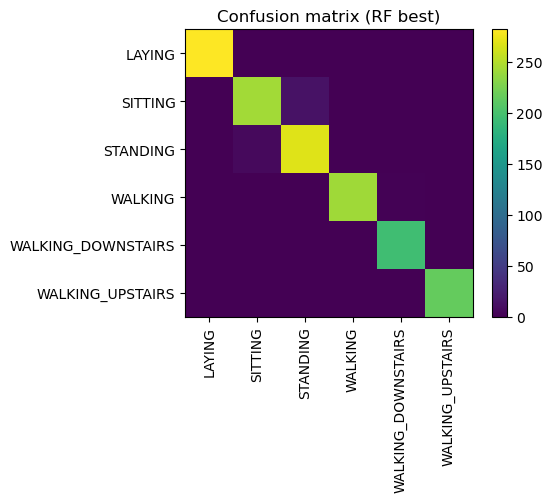

In [36]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.colorbar()
plt.xticks(range(len(le.classes_)), le.classes_, rotation=90); plt.yticks(range(len(le.classes_)), le.classes_)
plt.title('Confusion matrix (RF best)'); plt.tight_layout(); plt.show()

In [37]:
cm

array([[282,   0,   0,   0,   0,   0],
       [  0, 243,  14,   0,   0,   0],
       [  0,   7, 268,   0,   0,   0],
       [  0,   0,   0, 242,   2,   1],
       [  0,   0,   0,   1, 196,   0],
       [  0,   0,   0,   0,   0, 215]], dtype=int64)

In [38]:
# Predict on test if columns match
if set(df_reduced.columns).issubset(set(te.columns)):
    Xte = te[df_reduced.columns]
    Xte_scaled = scaler.transform(Xte)
    Xte_reduced = pd.DataFrame(Xte_scaled, columns=Xnum_cols).drop(columns=to_drop, errors='ignore')
    yte_pred = best_rf.predict(Xte_reduced)
    if 'Activity' in te.columns:
        yte_true = le.transform(te['Activity'])
        acc_te = accuracy_score(yte_true, yte_pred)
        print("Test accuracy:", acc_te)
    else:
        print("Test predictions sample:", le.inverse_transform(yte_pred)[:10])
else:
    print("Test set features do not match training features; skip test prediction.")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- angle(X,gravityMean)
- angle(Y,gravityMean)
- angle(Z,gravityMean)
- fBodyAcc-bandsEnergy()-1,16
- fBodyAcc-bandsEnergy()-1,16.1
- ...


In [39]:
# === Align test features to training features, handle missing training columns, scale, drop correlated, predict ===

# `tr` : training DataFrame used earlier
# `te` : test DataFrame
# `Xnum_cols` : list of numeric columns scaler was fit on (excluded 'subject')
# `scaler` : StandardScaler() fitted on tr[Xnum_cols]
# `to_drop` : list of features dropped due to very-high correlation (on scaled columns)
# `df_reduced` : DataFrame used to fit the model (scaled columns after dropping `to_drop`)
# `best_rf` : trained sklearn model (RandomForest best),
# `le` : LabelEncoder fitted on training Activity classes

# 1) Build numeric test-frame containing exactly training numeric columns.
Xte_num = pd.DataFrame(index=te.index)   # will hold raw numeric test columns in training order

# use training medians to impute any missing training feature in the test set
train_medians = tr[Xnum_cols].median()

for c in Xnum_cols:
    if c in te.columns:
        Xte_num[c] = te[c].astype(float)   # ensure numeric dtype
    else:
        # column completely missing in test — fill with training median
        Xte_num[c] = train_medians[c]
        # Optionally: warn/log:
        print(f"Warning: test set missing column '{c}'. Filling with training median ({train_medians[c]:.6f}).")

# 2) Apply the same StandardScaler (fitted on training Xnum_cols)
Xte_scaled = scaler.transform(Xte_num)                # numpy array
Xte_scaled_df = pd.DataFrame(Xte_scaled, columns=Xnum_cols, index=te.index)

# 3) Drop the same highly-correlated features you dropped during training
Xte_reduced = Xte_scaled_df.drop(columns=to_drop, errors='ignore')

# 4) Reorder columns to match training DataFrame used by model (df_reduced)
#    This ensures the model sees exactly the same column names in the same order.
missing_cols_after_drop = [c for c in df_reduced.columns if c not in Xte_reduced.columns]
if missing_cols_after_drop:
    # This shouldn't normally happen because we imputed missing training numeric cols earlier,
    # but guard against it:
    for c in missing_cols_after_drop:
        Xte_reduced[c] = 0.0
        print(f"Warning: after drop, still missing column '{c}' — filling with 0.0 to keep shapes consistent.")

Xte_reduced = Xte_reduced[df_reduced.columns]  # reorder (and will raise KeyError if someone removed required cols unexpectedly)

# 5) Predict
yte_pred = best_rf.predict(Xte_reduced)

# If test has Activity labels, compute accuracy; otherwise show a few predictions
if 'Activity' in te.columns:
    try:
        yte_true = le.transform(te['Activity'])
        acc_te = accuracy_score(yte_true, yte_pred)
        print("Test accuracy:", acc_te)
    except Exception as e:
        # If test Activity has unseen labels or mismatch with LabelEncoder, print sample preds
        print("Could not compute accuracy (label encoder mismatch). Sample predictions:")
        print(le.inverse_transform(yte_pred)[:20])
else:
    print("Test predictions (sample):", le.inverse_transform(yte_pred)[:20])


C:\Users\91970\AppData\Local\Temp\ipykernel_19424\1864272142.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xte_num[c] = te[c].astype(float)   # ensure numeric dtype
C:\Users\91970\AppData\Local\Temp\ipykernel_19424\1864272142.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xte_num[c] = te[c].astype(float)   # ensure numeric dtype
C:\Users\91970\AppData\Local\Temp\ipykernel_19424\1864272142.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

Test accuracy: 0.9419748897183576
